# Predicting Bike Rentals

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

## Explore the data

In [2]:
#Use the pandas library to read bike_rental_hour.csv into the dataframe bike_rentals
bike_rentals = pd.read_csv('bike_rental_hour.csv')

#Print out the first few rows of bike_rentals and take a look at the data.
bike_rentals.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


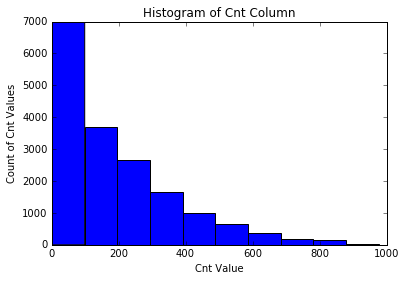

In [15]:
#Make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.
plt.hist(bike_rentals['cnt'])
plt.xlabel('Cnt Value')
plt.ylabel('Count of Cnt Values')
plt.title('Histogram of Cnt Column')
plt.show()

In [8]:
#Use the corr method on the bike_rentals dataframe to explore how each column is correlated with cnt
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Prep the data

The hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [12]:
#Write a function called assign_label that takes in a numeric value for an hour, and returns 1, 2, 3, or 4
def assign_label(numeric_hour):
    if 0 <= numeric_hour <6:
        return 4
    elif 6 <= numeric_hour < 12:
        return 1
    elif 12 <= numeric_hour < 18:
        return 2
    elif 18 <= numeric_hour < 24:
        return 3
    
#Use the apply method on series objects to apply the function to each item in the hr column. Assign the result to the time_label column of bike_rentals.
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## Split the data

Before we can begin applying machine learning algorithms, we'll need to split the data into training and testing sets. 

This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

In [23]:
#Select 80% of the rows in bike_rentals to be part of the training set using the sample method on bike_rentals
train = bike_rentals.sample(n=round(len(bike_rentals)*.8))

#Select the rows that are in bike_rentals but not in train to be in the testing set. Assign the result to test
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Error metric

To find the optimal parameters for a linear regression model, we want to optimize the model's residual sum of squares (or RSS). Residual error describes the difference between the predicted values for the target column and the true values. We want this difference to be as small as possible for our predictive model.

## Predictor column selection

Create a list of predictor columns to use in training and predictions.

In [29]:
features = ['instant', 'mnth', 'time_label', 'weathersit', 'temp', 'hum']

In [30]:
#Check for missing values
train[features].isnull().sum()

instant       0
mnth          0
time_label    0
weathersit    0
temp          0
hum           0
dtype: int64

## Linear Regression Model

In [38]:
lr = LinearRegression()
lr.fit(train[features], train['cnt'])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(test[features])

train_linreg_rmse = np.sqrt(mean_squared_error(train_predictions, train['cnt']))
test_linreg_rmse = np.sqrt(mean_squared_error(test_predictions, test['cnt']))

print(train_linreg_rmse)
print(test_linreg_rmse)

139.01696742442738
142.54022096296424


## Decision Tree Model

Now we're ready to apply the decision tree algorithm. We'll be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [72]:
clf = DecisionTreeRegressor(min_samples_leaf=5)

clf.fit(train[features], train["cnt"])

train_predictions = clf.predict(train[features])
test_predictions = clf.predict(test[features])

train_tree_rmse = np.sqrt(mean_squared_error(train_predictions, train['cnt']))
test_tree_rmse = np.sqrt(mean_squared_error(test_predictions, test['cnt']))

print(train_tree_rmse)
print(test_tree_rmse)

85.7119651054595
129.54260367422296


We see that on the training data the decisoin tree overfit the data quite a bit, as the RMSE value is 85 compared to the test value sof 129. Nonetheless, as we anticipated the decision tree overall did have less error for the test data set overall than the linear regression model by a value of about 13.

## Random Forest Model

We can now apply the random forest algorithm, which improves on the decision tree algorithm. 

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [95]:
clf = RandomForestRegressor(min_samples_leaf=4)
clf.fit(train[features], train["cnt"])

train_predictions = clf.predict(train[features])
test_predictions = clf.predict(test[features])

train_rf_rmse = np.sqrt(mean_squared_error(train_predictions, train['cnt']))
test_rf_rmse = np.sqrt(mean_squared_error(test_predictions, test['cnt']))

print(train_rf_rmse)
print(test_rf_rmse)

83.40826716798205
116.92863634911939


Again, as anticipated we found that the Random Forest model has less error in the test set than the simple decision tree model by a value of about 12.

## Next Steps

- Refine the paramters of the Random Forest model more to see if the RMSE can be lowered further
- Calculate additional features, such as:
    - An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt.